In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import scipy.io
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

from math import sqrt

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(1, '../utilities/')
from helpers import *
from plots import *

# Load of training data

The ID indicates both the user and the item : user are identified as "r"+"index" from 1 to 10000, and items as "c"+ "index" from 1 to 1000. The format of the ID are consequently : r index(user) _ c index(item).
The ratings are given as integers from 1 to 5.

We compute them into a matrix with items as row and users as columns. All of the missing ratings are set as 0 and should be predicted to have a valid rating format.

In [3]:
DATA_TRAIN_PATH = '../Datasets/data_train.csv'
ratings = load_data(DATA_TRAIN_PATH)

number of items: 1000, number of users: 10000


In [4]:
ratings.shape

(1000, 10000)

# Data analysis

### Plot the number of ratings per movie and user

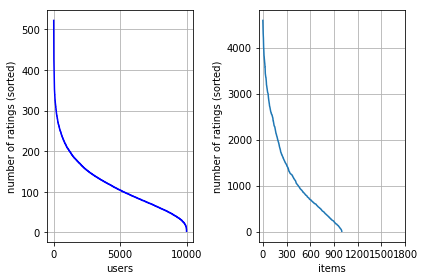

min # of items per user = 3, min # of users per item = 8.


In [5]:
num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Data preprocessing - Split the data into a train and test set

In [6]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    # split the data and return train and test data.
    # we only consider users and movies that have more than 10 ratings

    ind_test = np.random.choice(valid_ratings.nnz, int(valid_ratings.nnz*p_test), replace=False)
    ind_train = np.delete(np.arange(valid_ratings.nnz),ind_test)
    
    valid_ratings_coo = valid_ratings.tocoo()
    data = valid_ratings_coo.data
    row = valid_ratings_coo.row
    col = valid_ratings_coo.col
    
    test = sp.coo_matrix((data[ind_test], (row[ind_test], col[ind_test])), shape=valid_ratings.get_shape())
    train = sp.coo_matrix((data[ind_train], (row[ind_train], col[ind_train])), shape=valid_ratings.get_shape()) 
    
    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1059186
Total number of nonzero elements in test data:117687


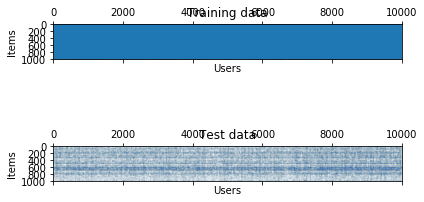

In [7]:
valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
plot_train_test_data(train, test)

# Standard implementations

## Implementing Baselines 

### Use the global mean to do the prediction

In [8]:
def baseline_global_mean(train, test):
    """baseline method: use the global mean."""  
    
    return sqrt(calculate_mse(test.data,np.mean(train.data))/(test.nnz))

baseline_global_mean(train, test)

1.1167843007553209

### Use the user means as the prediction

In [9]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    
    #Sum over nth user
    sum_ratings_movie = np.squeeze(np.asarray(train.sum(0)))    # sum of the nonzero elements, for each row
    count_ratings_movie = np.diff(train.tocsc().indptr)         # count of the nonzero elements, for each row
    mean_rating_movie = sum_ratings_movie/count_ratings_movie
    return sqrt(calculate_mse(test.data,mean_rating_movie[test.col])/(test.nnz))

baseline_user_mean(train, test)

1.0943344686705307

### Use the item means as prediction

In [10]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    
    #Sum over dth movie
    sum_ratings_user = np.squeeze(np.asarray(train.sum(1)))    # sum of the nonzero elements, for each row
    count_ratings_user = np.diff(train.tocsr().indptr)         # count of the nonzero elements, for each row
    mean_rating_user = sum_ratings_user/count_ratings_user

    return sqrt(calculate_mse(test.data,mean_rating_user[test.row])/(test.nnz))
    
baseline_item_mean(train, test)

1.0292360165304137

### Use the item/user means as prediction

In [78]:
from scipy.sparse.linalg import spsolve

def baseline_item_user(train, test):
    """baseline method: find best parameters for the model y_dn = w_0 + w_item[d] + w_user[n] (D+N+1) parameters
       and make a prediction."""
    
    global_mean = np.mean(train.data)
    
    #Sum over nth user
    sum_ratings_movie = np.squeeze(np.asarray(train.sum(0)))    # sum of the nonzero elements, for each row
    count_ratings_movie = np.diff(train.tocsc().indptr)         # count of the nonzero elements, for each row
    
    #Sum over dth movie
    sum_ratings_user = np.squeeze(np.asarray(train.sum(1)))    # sum of the nonzero elements, for each col
    count_ratings_user = np.diff(train.tocsr().indptr)         # count of the nonzero elements, for each col
    
    num_items, num_users = train.shape
    
    # Constructing linear system defining the model's optimal parameters in form of a matrix
    
    # Matrix of the same shape as ratings, 1 if rating present, 0 otherwise
    mask_train = sp.coo_matrix((np.ones(train.nnz), (train.row, train.col)), shape=train.shape) 
    
    A = sp.hstack((sp.diags(count_ratings_user), mask_train))
    A = sp.vstack((A, sp.hstack((mask_train.T, sp.diags(count_ratings_movie)))))
    A = sp.hstack((A, sp.coo_matrix(np.concatenate((count_ratings_movie,count_ratings_user))).T))
    A = sp.vstack((A, sp.coo_matrix(np.ones(num_items+num_users+1))))
    
    b = np.append(np.concatenate((sum_ratings_user, sum_ratings_movie)),global_mean)
    
    # Solving the system
    x = spsolve(A.tocsc(),b)
    
    # Extracting the parameters w_0, w_item[d] and w_user[n] 
    w_item, w_user, w_0 = np.split(x,np.array([num_items,num_items+num_users]))
    
    plt.scatter(w_item[test.row] + w_user[test.col] + w_0, test.data)
    
    return sqrt(calculate_mse(test.data, w_item[test.row] + w_user[test.col] + w_0)/(test.nnz))
    
baseline_item_user(train, test)

1.0002486362462182

### Learn the Matrix Factorization using SGD

#### Initialize matrix factorization

In [11]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    
    # returns initialized with random values :
    #     user_features: shape = num_features, num_user
    #     item_features: shape = num_features, num_item

    
    max_initial_value = 2*sqrt(np.mean(train.data)/num_features)
    
    user_features = max_initial_value*np.random.rand(num_features, train.shape[1])
    item_features = max_initial_value*np.random.rand(num_features, train.shape[0])

    
    return user_features,item_features

In [12]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""

    # calculate rmse (we only consider nonzero entries.)
    approx_data_matrix = np.dot(item_features.T,user_features)
    return sqrt(calculate_mse(data,approx_data_matrix[nz])/(len(data)))

#### Matrix factorization SGD basic

In [13]:
def matrix_factorization_SGD(train, test):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.05
    num_features = 25   # K in the lecture notes
    num_epochs = 30     # number of full iterations through the train set
    errors = [0]
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col, train.data))

    print("learn the matrix factorization using SGD...")
    rmse_tr = compute_error(train.data, user_features, item_features, train.nonzero())
    rmse_te = compute_error(test.data, user_features, item_features, test.nonzero())
    print("initial RMSE on training set: {}, RMSE on testing set: {}.".format(rmse_tr,rmse_te))
    
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
        
        for d, n, x_dn in nz_train:
        # update matrix factorization.     

            item_features[:,d] += gamma*(x_dn - np.inner(item_features[:,d],user_features[:,n]))*user_features[:,n]
            user_features[:,n] += gamma*(x_dn - np.inner(item_features[:,d],user_features[:,n]))*item_features[:,d]
        
        rmse_tr = compute_error(train.data, user_features, item_features, train.nonzero())
        rmse_te = compute_error(test.data, user_features, item_features, test.nonzero())
        print("iter: {}, RMSE on training set: {}, RMSE on testing set: {}.".format(it, rmse_tr,rmse_te))
        
        errors.append(rmse_te)

    # evaluate the test error.
    rmse = compute_error(test.data, user_features, item_features, test.nonzero())
    print("RMSE on test data: {}.".format(rmse))

matrix_factorization_SGD(train, test)

learn the matrix factorization using SGD...
initial RMSE on training set: 1.3071287373574476, RMSE on testing set: 1.3052388688004901.
iter: 0, RMSE on training set: 1.0679046970987307, RMSE on testing set: 1.1028435045814358.
iter: 1, RMSE on training set: 1.039899090892994, RMSE on testing set: 1.099446723942877.
iter: 2, RMSE on training set: 1.0125700340876733, RMSE on testing set: 1.0992430579902652.


KeyboardInterrupt: 

#### Matrix factorization SGD regularized

In [31]:
def matrix_factorization_SGD_regularized(train, test, num_features, lambda_user, lambda_item, gamma, gamma_dec_step_size, num_epochs, seed, stop_criterion):
    """matrix factorization by SGD."""
    
    # set seed
    np.random.seed(seed)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices  
    nz_train = list(zip(train.row, train.col, train.data))
    
    print("learn the matrix factorization using SGD...")
    rmse_tr = [compute_error(train.data, user_features, item_features, train.nonzero())]
    rmse_te = [compute_error(test.data, user_features, item_features, test.nonzero())]
    print("initial RMSE on training set: {}, RMSE on testing set: {}.".format(rmse_tr[0],rmse_te[0]))
    
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= gamma_dec_step_size
        
        for d, n, x_dn in nz_train:
        # update matrix factorization.

            item_features[:,d] += gamma*((x_dn - np.inner(item_features[:,d],user_features[:,n]))*user_features[:,n]-lambda_item*item_features[:,d])
            user_features[:,n] += gamma*((x_dn - np.inner(item_features[:,d],user_features[:,n]))*item_features[:,d]-lambda_user*user_features[:,n])
        
        rmse_tr.append(compute_error(train.data, user_features, item_features, train.nonzero()))
        rmse_te.append(compute_error(test.data, user_features, item_features, test.nonzero()))
        print("iter: {}, RMSE on training set: {}, RMSE on testing set: {}.".format(it, rmse_tr[-1],rmse_te[-1]))
        
        if np.isclose(rmse_tr[-1],rmse_tr[-2],stop_criterion) or rmse_tr[-1] > rmse_tr[0]:
            break
            
    # evaluate the test error.
    min_rmse_te = min(rmse_te)
    print("RMSE on test data: {}.".format(min_rmse_te))
    
    return min_rmse_te


In [ ]:
# define parameters 
num_features = 40   # K in the lecture notes

lambda_user = 0.08
lambda_item = 0.08
    
gamma = 0.05
gamma_dec_step_size = 1.2
num_epochs = 30     # number of full passes through the train set
stop_criterion = 1e-4
    
seed = 988

matrix_factorization_SGD_regularized(train, test, num_features, lambda_user, lambda_item, gamma, gamma_dec_step_size, num_epochs, seed, stop_criterion)


##### Tuning Hyperparameters

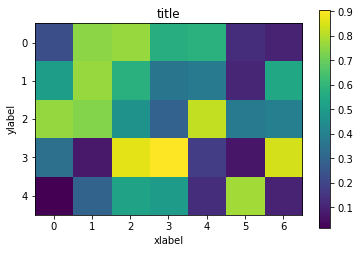

In [66]:
def plot_simple_heatmap(data, title, xlabel, xticklabels, ylabel, yticklabels):

    f,a = plt.subplots()
    a.set_xlabel(xlabel)
    a.set_xticks(range(len(xticklabels)))
    a.set_xticklabels(xticklabels)
    a.set_ylabel(ylabel)
    a.set_yticks(range(len(yticklabels)))
    a.set_yticklabels(yticklabels)
    a.set_title(title)
    heatmap_corr = a.imshow(data)
    f.colorbar(heatmap_corr, ax=a)
    
data = np.random.rand(5,7)
plot_simple_heatmap(data, "title", "xlabel",np.arange(7), "ylabel",np.arange(5))

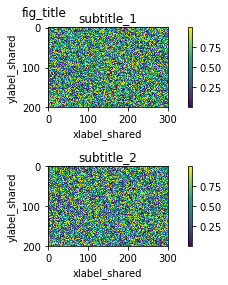

In [77]:
def plot_simple_heatmaps(data_1, data_2, fig_title, subtitle_1, subtitle_2, xlabel_shared, ylabel_shared):

    f,a = plt.subplots(2,1)
    
    a[0].set_xlabel(xlabel_shared)
    a[0].set_ylabel(ylabel_shared)
    a[0].set_title(subtitle_1)
    heatmap_0 = a[0].imshow(data_1)

    a[1].set_xlabel(xlabel_shared)
    a[1].set_ylabel(ylabel_shared)
    a[1].set_title(subtitle_2)
    heatmap_1 = a[1].imshow(data_2)

    plt.tight_layout()
    
    f.colorbar(heatmap_0,ax=a[0])
    f.colorbar(heatmap_1,ax=a[1])
    
    f.suptitle(fig_title)
    
data_1 = np.random.rand(200,300)
data_2 = np.random.rand(200,300)
plot_simple_heatmaps(data_1, data_2, 'fig_title', 'subtitle_1', 'subtitle_2', 'xlabel_shared', 'ylabel_shared')

Finding the best initial gamma and the best decrement step size to compare SGD with ALS.

In [41]:
"""
# define parameters 
num_features = 25   # K in the lecture notes

lambda_user = 0.08
lambda_item = 0.08
    
gammas = np.logspace(-2,-1,num = 5)
gamma_dec_step_sizes = np.linspace(1.1,1.3,5)


num_epochs = 30     # number of full passes through the train set
stop_criterion = 1e-4
    
seeds = np.array([988,1000])
#seeds = np.array([988])

rmse_te = np.zeros((len(seeds),len(gammas),len(gamma_dec_step_sizes)))

for ind_seed, seed in enumerate(seeds):
    for ind_gamma, gamma in enumerate(gammas):
        for ind_gamma_dec_step_size, gamma_dec_step_size in enumerate(gamma_dec_step_sizes):
            print("seed ({}/{}) = {}".format(ind_seed+1, len(seeds), seed))
            print("gamma ({}/{}) = {}".format(ind_gamma+1, len(gammas), gamma))
            print("stepsize decrement ({}/{}) = {}".format(ind_gamma_dec_step_size+1, len(gamma_dec_step_sizes), gamma_dec_step_size))
            
            rmse_te[ind_seed,ind_gamma,ind_gamma_dec_step_size] = matrix_factorization_SGD_regularized(train, test, num_features, lambda_user, lambda_item, gamma, gamma_dec_step_size, num_epochs, seed, stop_criterion)

np.save('../results_of_lengthy_computations/RMSE_test_tuning_gammas',rmse_te)
"""

seed (1/2) = 988
gamma (1/5) = 0.01
stepsize decrement (1/5) = 1.1
learn the matrix factorization using SGD...
initial RMSE on training set: 1.3071287373574476, RMSE on testing set: 1.3052388688004901.
iter: 0, RMSE on training set: 1.0043474025543135, RMSE on testing set: 1.0206585722434725.
iter: 1, RMSE on training set: 0.9986596275987056, RMSE on testing set: 1.0162054617478655.
iter: 2, RMSE on training set: 0.9971090060941443, RMSE on testing set: 1.0155509804238534.
iter: 3, RMSE on training set: 0.9953685258367746, RMSE on testing set: 1.013729521835026.
iter: 4, RMSE on training set: 0.9939093956696281, RMSE on testing set: 1.0124641307975963.
iter: 5, RMSE on training set: 0.9927732459514989, RMSE on testing set: 1.0120238078044104.
iter: 6, RMSE on training set: 0.9908446237976789, RMSE on testing set: 1.010601439225823.
iter: 7, RMSE on training set: 0.9907652944194636, RMSE on testing set: 1.0103972623167314.
RMSE on test data: 1.0103972623167314.
seed (1/2) = 988
gamma (1

iter: 14, RMSE on training set: 0.9748374219866324, RMSE on testing set: 1.0040275377770467.
iter: 15, RMSE on training set: 0.9727227150758277, RMSE on testing set: 1.002731740554432.
iter: 16, RMSE on training set: 0.9713469186103728, RMSE on testing set: 1.0017856399812364.
iter: 17, RMSE on training set: 0.9694652460885098, RMSE on testing set: 1.0008632633162697.
iter: 18, RMSE on training set: 0.9680212591443036, RMSE on testing set: 1.0001403552916597.
iter: 19, RMSE on training set: 0.9669184196611782, RMSE on testing set: 0.9993120620927223.
iter: 20, RMSE on training set: 0.9657591731198611, RMSE on testing set: 0.9992464819104578.
iter: 21, RMSE on training set: 0.9647406890459178, RMSE on testing set: 0.9984882199701653.
iter: 22, RMSE on training set: 0.9638722430216375, RMSE on testing set: 0.9978022252551422.
iter: 23, RMSE on training set: 0.9632731484481675, RMSE on testing set: 0.9978743029561679.
iter: 24, RMSE on training set: 0.9626298631730632, RMSE on testing set

iter: 2, RMSE on training set: 0.9976054099661935, RMSE on testing set: 1.016374901939589.
iter: 3, RMSE on training set: 0.993908819271057, RMSE on testing set: 1.0126041925634646.
iter: 4, RMSE on training set: 0.9912361759613241, RMSE on testing set: 1.0101045792010845.
iter: 5, RMSE on training set: 0.9893921338888254, RMSE on testing set: 1.0089037345509304.
iter: 6, RMSE on training set: 0.9874647992371139, RMSE on testing set: 1.0071944648131763.
iter: 7, RMSE on training set: 0.9869749403984214, RMSE on testing set: 1.0065802661569163.
iter: 8, RMSE on training set: 0.9859207210515455, RMSE on testing set: 1.0056340792067484.
iter: 9, RMSE on training set: 0.9857196030438562, RMSE on testing set: 1.005421266527829.
iter: 10, RMSE on training set: 0.9855137737626929, RMSE on testing set: 1.0053592454053697.
iter: 11, RMSE on training set: 0.9850019102488605, RMSE on testing set: 1.0050287561983213.
iter: 12, RMSE on training set: 0.9849856562073047, RMSE on testing set: 1.004962

iter: 10, RMSE on training set: 0.9759236926778029, RMSE on testing set: 1.0043466867104356.
iter: 11, RMSE on training set: 0.9729879385670273, RMSE on testing set: 1.0026483544514464.
iter: 12, RMSE on training set: 0.9715679540087122, RMSE on testing set: 1.0015480751140644.
iter: 13, RMSE on training set: 0.970010835859183, RMSE on testing set: 1.0005617337212973.
iter: 14, RMSE on training set: 0.9689802525929153, RMSE on testing set: 1.0001780382472714.
iter: 15, RMSE on training set: 0.9675683403422192, RMSE on testing set: 0.9992110585704738.
iter: 16, RMSE on training set: 0.9671423278134528, RMSE on testing set: 0.9989288284013965.
iter: 17, RMSE on training set: 0.9661970279488611, RMSE on testing set: 0.9983884343169496.
iter: 18, RMSE on training set: 0.9658058808147756, RMSE on testing set: 0.9981946137417255.
iter: 19, RMSE on training set: 0.9654386513763039, RMSE on testing set: 0.9980057415992654.
iter: 20, RMSE on training set: 0.9650747340471068, RMSE on testing set

learn the matrix factorization using SGD...
initial RMSE on training set: 1.3071287373574476, RMSE on testing set: 1.3052388688004901.
iter: 0, RMSE on training set: 1.076170387217374, RMSE on testing set: 1.0932474686778764.
iter: 1, RMSE on training set: 1.0599423690200538, RMSE on testing set: 1.078630697348137.
iter: 2, RMSE on training set: 1.0456213146300177, RMSE on testing set: 1.0699016701188067.
iter: 3, RMSE on training set: 1.0264815451280542, RMSE on testing set: 1.0533030101751368.
iter: 4, RMSE on training set: 1.0118013096807237, RMSE on testing set: 1.0428723444337094.
iter: 5, RMSE on training set: 0.9972517996010645, RMSE on testing set: 1.0339418237823848.
iter: 6, RMSE on training set: 0.9821232371737598, RMSE on testing set: 1.0246492154835796.
iter: 7, RMSE on training set: 0.9757749447679065, RMSE on testing set: 1.0226657617174983.
iter: 8, RMSE on training set: 0.9644901964428947, RMSE on testing set: 1.0144485913526131.
iter: 9, RMSE on training set: 0.955622

iter: 0, RMSE on training set: 1.0651895030335432, RMSE on testing set: 1.0822216300182217.
iter: 1, RMSE on training set: 1.0416664500456587, RMSE on testing set: 1.060060961746787.
iter: 2, RMSE on training set: 1.0262117098560728, RMSE on testing set: 1.0488851344392232.
iter: 3, RMSE on training set: 1.0099957947513427, RMSE on testing set: 1.0335350301927413.
iter: 4, RMSE on training set: 0.9978917733577818, RMSE on testing set: 1.0236994140818747.
iter: 5, RMSE on training set: 0.9884373917086673, RMSE on testing set: 1.0170926717339857.
iter: 6, RMSE on training set: 0.9792334296415179, RMSE on testing set: 1.0104626644813437.
iter: 7, RMSE on training set: 0.9749541740726321, RMSE on testing set: 1.007386839786374.
iter: 8, RMSE on training set: 0.969262575929632, RMSE on testing set: 1.0026796094110793.
iter: 9, RMSE on training set: 0.9661987674184603, RMSE on testing set: 1.0004321711562538.
iter: 10, RMSE on training set: 0.964333289772305, RMSE on testing set: 0.999594793

iter: 2, RMSE on training set: 1.0812488660618647, RMSE on testing set: 1.108844475967468.
iter: 3, RMSE on training set: 1.0475514010568039, RMSE on testing set: 1.08087560074516.
iter: 4, RMSE on training set: 1.0241890604766577, RMSE on testing set: 1.0634449660258045.
iter: 5, RMSE on training set: 0.9995540359001054, RMSE on testing set: 1.046288693408882.
iter: 6, RMSE on training set: 0.9789853896115176, RMSE on testing set: 1.0329141417311531.
iter: 7, RMSE on training set: 0.9699803460083528, RMSE on testing set: 1.0293224770552254.
iter: 8, RMSE on training set: 0.95554361020384, RMSE on testing set: 1.0183794826178483.
iter: 9, RMSE on training set: 0.9443598866096158, RMSE on testing set: 1.0102671466232644.
iter: 10, RMSE on training set: 0.9377848267370434, RMSE on testing set: 1.0071454045891104.
iter: 11, RMSE on training set: 0.9306015141170382, RMSE on testing set: 1.0031684155354772.
iter: 12, RMSE on training set: 0.9252531954636226, RMSE on testing set: 0.999496914

iter: 8, RMSE on training set: 0.9889255503633155, RMSE on testing set: 1.0082509877907915.
iter: 9, RMSE on training set: 0.9887503267738482, RMSE on testing set: 1.0081605847907213.
iter: 10, RMSE on training set: 0.9875019379945019, RMSE on testing set: 1.007668065867483.
iter: 11, RMSE on training set: 0.9865923642852108, RMSE on testing set: 1.007160437274455.
iter: 12, RMSE on training set: 0.9854118201000933, RMSE on testing set: 1.0062758052216174.
iter: 13, RMSE on training set: 0.9852763890333788, RMSE on testing set: 1.006613045243883.
iter: 14, RMSE on training set: 0.9843543236545939, RMSE on testing set: 1.0060942795186918.
iter: 15, RMSE on training set: 0.9841140099531585, RMSE on testing set: 1.0059501277461607.
iter: 16, RMSE on training set: 0.9831953880702502, RMSE on testing set: 1.005070122827332.
iter: 17, RMSE on training set: 0.9832166711129235, RMSE on testing set: 1.0053990410361249.
RMSE on test data: 1.005070122827332.
seed (2/2) = 1000
gamma (1/5) = 0.01
s

iter: 14, RMSE on training set: 0.9736196886797939, RMSE on testing set: 1.0035238624499603.
iter: 15, RMSE on training set: 0.9719818983701636, RMSE on testing set: 1.0025053872424532.
iter: 16, RMSE on training set: 0.9702147293625308, RMSE on testing set: 1.0013610592566211.
iter: 17, RMSE on training set: 0.9691544540596158, RMSE on testing set: 1.0011181666091147.
iter: 18, RMSE on training set: 0.9670522846254529, RMSE on testing set: 0.999598121213659.
iter: 19, RMSE on training set: 0.9659415348926059, RMSE on testing set: 0.9993852761172966.
iter: 20, RMSE on training set: 0.96542020594234, RMSE on testing set: 0.9992628441623216.
iter: 21, RMSE on training set: 0.9645525219209549, RMSE on testing set: 0.9987904313090582.
iter: 22, RMSE on training set: 0.963425140754242, RMSE on testing set: 0.998121526556485.
iter: 23, RMSE on training set: 0.9623615816187486, RMSE on testing set: 0.9971708786444937.
iter: 24, RMSE on training set: 0.9619778985477642, RMSE on testing set: 0.

learn the matrix factorization using SGD...
initial RMSE on training set: 1.2970036050983964, RMSE on testing set: 1.29779821218469.
iter: 0, RMSE on training set: 1.0366315356438576, RMSE on testing set: 1.05238086265254.
iter: 1, RMSE on training set: 1.0284922797404787, RMSE on testing set: 1.0467453317980062.
iter: 2, RMSE on training set: 1.0195239615188145, RMSE on testing set: 1.0410843269024685.
iter: 3, RMSE on training set: 1.0170830052656814, RMSE on testing set: 1.0378532894972754.
iter: 4, RMSE on training set: 1.00825032991507, RMSE on testing set: 1.031993775646359.
iter: 5, RMSE on training set: 0.9989597423152361, RMSE on testing set: 1.0275994550276775.
iter: 6, RMSE on training set: 0.9920520382961299, RMSE on testing set: 1.024105389279861.
iter: 7, RMSE on training set: 0.9841109289160528, RMSE on testing set: 1.0178753892310455.
iter: 8, RMSE on training set: 0.9776483911169144, RMSE on testing set: 1.0126438584100337.
iter: 9, RMSE on training set: 0.973507917955

learn the matrix factorization using SGD...
initial RMSE on training set: 1.2970036050983964, RMSE on testing set: 1.29779821218469.
iter: 0, RMSE on training set: 1.0301051663987693, RMSE on testing set: 1.0460288249197525.
iter: 1, RMSE on training set: 1.0177699582379767, RMSE on testing set: 1.0360751083906508.
iter: 2, RMSE on training set: 1.0079404174012414, RMSE on testing set: 1.02837591377164.
iter: 3, RMSE on training set: 1.0027315011584508, RMSE on testing set: 1.02191146021097.
iter: 4, RMSE on training set: 0.9965490068050225, RMSE on testing set: 1.017899400577585.
iter: 5, RMSE on training set: 0.991012700776991, RMSE on testing set: 1.0142090791787692.
iter: 6, RMSE on training set: 0.9873414896818622, RMSE on testing set: 1.0116943246477221.
iter: 7, RMSE on training set: 0.9836004570568598, RMSE on testing set: 1.0080170902387198.
iter: 8, RMSE on training set: 0.9813885129616443, RMSE on testing set: 1.0056999126611192.
iter: 9, RMSE on training set: 0.979992712897

iter: 15, RMSE on training set: 0.9289938700266822, RMSE on testing set: 0.995679566796169.
iter: 16, RMSE on training set: 0.9265271567965626, RMSE on testing set: 0.9943734059073065.
iter: 17, RMSE on training set: 0.9248105595166877, RMSE on testing set: 0.9938131388213528.
iter: 18, RMSE on training set: 0.9223948245085514, RMSE on testing set: 0.9922370811733948.
iter: 19, RMSE on training set: 0.9212029183697277, RMSE on testing set: 0.9920628210761671.
iter: 20, RMSE on training set: 0.9204255101509167, RMSE on testing set: 0.9917727655379388.
iter: 21, RMSE on training set: 0.9195534418080438, RMSE on testing set: 0.9913365199642186.
iter: 22, RMSE on training set: 0.918467668185552, RMSE on testing set: 0.9907277317871803.
iter: 23, RMSE on training set: 0.9174513000357498, RMSE on testing set: 0.989812945098644.
iter: 24, RMSE on training set: 0.9171360757811268, RMSE on testing set: 0.9901272963061761.
iter: 25, RMSE on training set: 0.9166025508574484, RMSE on testing set: 

learn the matrix factorization using SGD...
initial RMSE on training set: 1.2970036050983964, RMSE on testing set: 1.29779821218469.
iter: 0, RMSE on training set: 1.1735682353861963, RMSE on testing set: 1.1863181929751254.
iter: 1, RMSE on training set: 1.1421076862290616, RMSE on testing set: 1.1611793929617977.
iter: 2, RMSE on training set: 1.1132187146891637, RMSE on testing set: 1.1422227030240142.
iter: 3, RMSE on training set: 1.0997529304415292, RMSE on testing set: 1.1344670304644886.
iter: 4, RMSE on training set: 1.0657662087618185, RMSE on testing set: 1.1048552129692781.
iter: 5, RMSE on training set: 1.0480720826953969, RMSE on testing set: 1.1006159070579553.
iter: 6, RMSE on training set: 1.0214774531310242, RMSE on testing set: 1.0814697209299706.
iter: 7, RMSE on training set: 1.0051789437923622, RMSE on testing set: 1.0689949001492327.
iter: 8, RMSE on training set: 0.9870740563190599, RMSE on testing set: 1.054393059835235.
iter: 9, RMSE on training set: 0.9773561

iter: 22, RMSE on training set: 0.9077944479727176, RMSE on testing set: 0.9899491592216615.
iter: 23, RMSE on training set: 0.9071417938802203, RMSE on testing set: 0.9893192751199923.
iter: 24, RMSE on training set: 0.9069933429288145, RMSE on testing set: 0.9894676297693932.
iter: 25, RMSE on training set: 0.9067495195840831, RMSE on testing set: 0.9894104758080313.
iter: 26, RMSE on training set: 0.9062945621120335, RMSE on testing set: 0.9889724495983553.
iter: 27, RMSE on training set: 0.9061689948073758, RMSE on testing set: 0.989124603174705.
iter: 28, RMSE on training set: 0.9060512636196452, RMSE on testing set: 0.9889219611749384.
iter: 29, RMSE on training set: 0.90599450899746, RMSE on testing set: 0.988952637413697.
RMSE on test data: 0.9889219611749384.
seed (2/2) = 1000
gamma (5/5) = 0.1
stepsize decrement (4/5) = 1.25
learn the matrix factorization using SGD...
initial RMSE on training set: 1.2970036050983964, RMSE on testing set: 1.29779821218469.
iter: 0, RMSE on tra

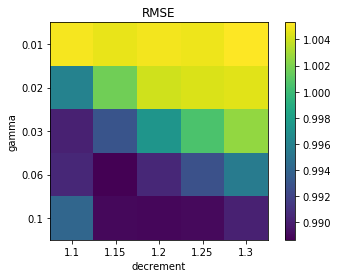

In [75]:
RMSE_test_tuning_lambdas = np.load('../results_of_lengthy_computations/RMSE_test_tuning_gammas.npy')
gammas = np.logspace(-2,-1,num = 5)
gamma_dec_step_sizes = np.linspace(1.1,1.3,5)
plot_simple_heatmap(np.min(RMSE_test_tuning_lambdas, axis = 0), "RMSE", "decrement",np.around(gamma_dec_step_sizes,2), "gamma",np.around(gammas,2))
plt.savefig('../plots/heatmap_tuning_gammas.png')

### Learn the Matrix Factorization using Alternating Least Squares

In [24]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    """the best lambda is assumed to be nnz_items_per_user[user] * lambda_user"""

    # update and return user feature.
    user_features = np.zeros((item_features.shape[0],train.shape[1]))
    
    for n in range(train.shape[1]):
        
        item_features_n = np.zeros(item_features.shape)
        item_features_n[:,nz_user_itemindices[n]] = item_features[:,nz_user_itemindices[n]]
        user_features[:,n] = np.linalg.solve(np.dot(item_features_n,item_features.T)+lambda_user*nnz_items_per_user[n]*np.identity(user_features.shape[0]),np.dot(item_features,np.squeeze(np.asarray(train.getcol(n).todense()))))
    
    return user_features

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    """the best lambda is assumed to be nnz_items_per_item[item] * lambda_item"""

    # update and return item feature.
    item_features = np.zeros((user_features.shape[0],train.shape[0]))
    
    for d in range(train.shape[0]):
        
        user_features_d = np.zeros(user_features.shape)
        user_features_d[:,nz_item_userindices[d]] = user_features[:,nz_item_userindices[d]]
        item_features[:,d] = np.linalg.solve(np.dot(user_features_d,user_features.T)+lambda_item*nnz_users_per_item[d]*np.identity(user_features.shape[0]),np.dot(user_features,np.squeeze(np.asarray(train.getrow(d).todense()))))
    
    return item_features

In [40]:
def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 25   # K in the lecture notes
    lambda_user = 0.08
    lambda_item = 0.08
    stop_criterion = 1e-4
    change = 1
    error_list = [[0, 0]]
    max_iter = 30
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    # start you ALS-WR algorithm. 
    
    nz_row, nz_col = train.nonzero()
    
    nz_user_itemindices = [nz_row[nz_col==n] for n in range(train.shape[1])]
    nnz_items_per_user = np.array([len(nz_user_itemindice) for nz_user_itemindice in nz_user_itemindices])
    nz_item_userindices = [nz_col[nz_row==d] for d in range(train.shape[0])]
    nnz_users_per_item = np.array([len(nz_item_userindice) for nz_item_userindice in nz_item_userindices])
    
    rmse_tr = compute_error(train.data, user_features, item_features, train.nonzero())
    rmse_te = compute_error(test.data, user_features, item_features, test.nonzero())
    print("initial: RMSE on training set: {}, RMSE on testing set: {}.".format(rmse_tr,rmse_te))
    error_list.append([rmse_tr,rmse_te])
    
    it = 0
    while (it < max_iter and not np.isclose(error_list[it][0],error_list[it+1][0],stop_criterion)):
        it += 1
        
        user_features = update_user_feature(train, item_features, lambda_user, nnz_items_per_user, nz_user_itemindices)
        item_features = update_item_feature(train, user_features, lambda_item, nnz_users_per_item, nz_item_userindices)
        
        rmse_tr = compute_error(train.data, user_features, item_features, train.nonzero())
        rmse_te = compute_error(test.data, user_features, item_features, test.nonzero())
        print("iter: {}, RMSE on training set: {}, RMSE on testing set: {}.".format(it, rmse_tr,rmse_te))
        
        error_list.append([rmse_tr,rmse_te])
        
    rmse = compute_error(test.data, user_features, item_features, test.nonzero())
    print("RMSE on test data: {}.".format(rmse))
       

ALS(train, test)

initial: RMSE on training set: 1.3071287373574476, RMSE on testing set: 1.3052388688004901.
iter: 1, RMSE on training set: 0.9519054032723246, RMSE on testing set: 1.017714471190868.
iter: 2, RMSE on training set: 0.9315802604917478, RMSE on testing set: 1.003362815799362.
iter: 3, RMSE on training set: 0.9100196143174027, RMSE on testing set: 0.9968938521418712.
iter: 4, RMSE on training set: 0.8978135873998376, RMSE on testing set: 0.9935087567550255.
iter: 5, RMSE on training set: 0.8908915580800574, RMSE on testing set: 0.9917070102761273.
iter: 6, RMSE on training set: 0.8865317019111828, RMSE on testing set: 0.9905511255013821.
iter: 7, RMSE on training set: 0.8836344304523723, RMSE on testing set: 0.9897784422755475.
iter: 8, RMSE on training set: 0.8816238424159367, RMSE on testing set: 0.9892569669449173.
iter: 9, RMSE on training set: 0.8801742015688895, RMSE on testing set: 0.9888997474217414.
iter: 10, RMSE on training set: 0.8790928220247602, RMSE on testing set: 0.9886478

Finding the best ridge parameters using ALS

In [28]:
def ALS(train, test, num_features, lambda_user, lambda_item, max_iter, seed):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    # start you ALS-WR algorithm. 
    
    nz_row, nz_col = train.nonzero()
    
    nz_user_itemindices = [nz_row[nz_col==n] for n in range(train.shape[1])]
    nnz_items_per_user = np.array([len(nz_user_itemindice) for nz_user_itemindice in nz_user_itemindices])
    nz_item_userindices = [nz_col[nz_row==d] for d in range(train.shape[0])]
    nnz_users_per_item = np.array([len(nz_item_userindice) for nz_item_userindice in nz_item_userindices])
    
    rmse_tr = [compute_error(train.data, user_features, item_features, train.nonzero())]
    rmse_te = [compute_error(test.data, user_features, item_features, test.nonzero())]
    print("initial: RMSE on training set: {}, RMSE on testing set: {}.".format(rmse_tr[0],rmse_te[0]))
    

    for it in range(max_iter):
        
        user_features = update_user_feature(train, item_features, lambda_user, nnz_items_per_user, nz_user_itemindices)
        item_features = update_item_feature(train, user_features, lambda_item, nnz_users_per_item, nz_item_userindices)
        
        
        
        rmse_tr.append(compute_error(train.data, user_features, item_features, train.nonzero()))
        rmse_te.append(compute_error(test.data, user_features, item_features, test.nonzero()))
        print("iter: {}, RMSE on training set: {}, RMSE on testing set: {}.".format(it, rmse_tr[-1],rmse_te[-1]))
        
        if np.isclose(rmse_tr[-1],rmse_tr[-2],stop_criterion) or rmse_tr[-1] > rmse_tr[0]:
            break
        
    min_rmse_te = min(rmse_te)
    print("RMSE on test data: {}.".format(min_rmse_te))
    
    return min_rmse_te


In [30]:
"""
# define parameters 
num_features = 25   # K in the lecture notes
lambda_users = np.logspace(-2,0,num = 5)
lambda_items = np.logspace(-2,0,num = 5)
stop_criterion = 1e-4
max_iter = 15
    
seeds = np.array([988])

rmse_te = np.zeros((len(seeds),len(lambda_users),len(lambda_items)))

for ind_seed, seed in enumerate(seeds):
    for ind_lambda_user, lambda_user in enumerate(lambda_users):
        for ind_lambda_item, lambda_item in enumerate(lambda_items):
            print("seed ({}/{}) = {}".format(ind_seed+1, len(seeds), seed))
            print("lambda_user ({}/{}) = {}".format(ind_lambda_user+1, len(lambda_users), lambda_user))
            print("lambda_item ({}/{}) = {}".format(ind_lambda_item+1, len(lambda_items), lambda_item))
            
            rmse_te[ind_seed,ind_lambda_user,ind_lambda_item] = ALS(train, test, num_features, lambda_user, lambda_item, max_iter, seed)

np.save('../results_of_lengthy_computations/RMSE_test_tuning_lambdas',rmse_te)
"""

seed (1/2) = 988
lambda_user (1/5) = 0.01
lambda_item (1/5) = 0.01
initial: RMSE on training set: 1.3071287373574476, RMSE on testing set: 1.3052388688004901.
iter: 0, RMSE on training set: 0.8900565026826133, RMSE on testing set: 1.1118608935236363.
iter: 1, RMSE on training set: 0.8342085828124343, RMSE on testing set: 1.1225309771157455.
iter: 2, RMSE on training set: 0.8133488350042751, RMSE on testing set: 1.1283590561540568.
iter: 3, RMSE on training set: 0.8010823757779079, RMSE on testing set: 1.1313845872509731.
iter: 4, RMSE on training set: 0.7935083863398478, RMSE on testing set: 1.1334478648264252.
iter: 5, RMSE on training set: 0.7883764678435841, RMSE on testing set: 1.1348352328992795.
iter: 6, RMSE on training set: 0.7846249722272582, RMSE on testing set: 1.1356865547654404.
iter: 7, RMSE on training set: 0.7817472101536694, RMSE on testing set: 1.1361911874474637.
iter: 8, RMSE on training set: 0.7794757455419334, RMSE on testing set: 1.136540853793994.
iter: 9, RMSE 

iter: 1, RMSE on training set: 0.8372514314063599, RMSE on testing set: 1.0914120178638937.
iter: 2, RMSE on training set: 0.8161801104047228, RMSE on testing set: 1.0928806956586785.
iter: 3, RMSE on training set: 0.8045893077900117, RMSE on testing set: 1.092560265646262.
iter: 4, RMSE on training set: 0.7975613191882547, RMSE on testing set: 1.0922531057556788.
iter: 5, RMSE on training set: 0.7927980147165042, RMSE on testing set: 1.0918991798805249.
iter: 6, RMSE on training set: 0.7893294474054723, RMSE on testing set: 1.0915153228824923.
iter: 7, RMSE on training set: 0.7867006457153481, RMSE on testing set: 1.0911927827120902.
iter: 8, RMSE on training set: 0.7846586062143702, RMSE on testing set: 1.090990492447238.
iter: 9, RMSE on training set: 0.7830402010326099, RMSE on testing set: 1.0909052158622115.
iter: 10, RMSE on training set: 0.7817302122482407, RMSE on testing set: 1.090905747137122.
iter: 11, RMSE on training set: 0.7806462263116024, RMSE on testing set: 1.0909642

iter: 4, RMSE on training set: 0.8111121101104043, RMSE on testing set: 1.0464046780805087.
iter: 5, RMSE on training set: 0.8065919532576101, RMSE on testing set: 1.0452783567651454.
iter: 6, RMSE on training set: 0.8033733225362337, RMSE on testing set: 1.0444575575764936.
iter: 7, RMSE on training set: 0.8010062750144732, RMSE on testing set: 1.0439095475542632.
iter: 8, RMSE on training set: 0.7992169856183156, RMSE on testing set: 1.0435710578241628.
iter: 9, RMSE on training set: 0.7978259451003644, RMSE on testing set: 1.043374983097363.
iter: 10, RMSE on training set: 0.7967135898828998, RMSE on testing set: 1.0432713434558039.
iter: 11, RMSE on training set: 0.7958009012021671, RMSE on testing set: 1.0432270711180978.
iter: 12, RMSE on training set: 0.7950357774003795, RMSE on testing set: 1.043219953287221.
iter: 13, RMSE on training set: 0.7943833986269679, RMSE on testing set: 1.0432345776720224.
iter: 14, RMSE on training set: 0.7938198961465427, RMSE on testing set: 1.043

iter: 7, RMSE on training set: 0.8367445939181022, RMSE on testing set: 1.0017512851588835.
iter: 8, RMSE on training set: 0.8352187477557332, RMSE on testing set: 1.0014827897312868.
iter: 9, RMSE on training set: 0.8340625258810938, RMSE on testing set: 1.0013211054220676.
iter: 10, RMSE on training set: 0.8331609605728901, RMSE on testing set: 1.0012198625155417.
iter: 11, RMSE on training set: 0.8324413351239834, RMSE on testing set: 1.0011536113793167.
iter: 12, RMSE on training set: 0.8318560417861505, RMSE on testing set: 1.001108682766672.
iter: 13, RMSE on training set: 0.8313727794512211, RMSE on testing set: 1.001077531694877.
iter: 14, RMSE on training set: 0.8309688660576576, RMSE on testing set: 1.001055708580811.
RMSE on test data: 1.001055708580811.
seed (1/2) = 988
lambda_user (4/5) = 0.31622776601683794
lambda_item (2/5) = 0.03162277660168379
initial: RMSE on training set: 1.3071287373574476, RMSE on testing set: 1.3052388688004901.
iter: 0, RMSE on training set: 0.97

initial: RMSE on training set: 1.3071287373574476, RMSE on testing set: 1.3052388688004901.
iter: 0, RMSE on training set: 1.0072873723081912, RMSE on testing set: 1.0190256179512769.
iter: 1, RMSE on training set: 1.0098585915006129, RMSE on testing set: 1.020243622316415.
iter: 2, RMSE on training set: 1.0161685532013376, RMSE on testing set: 1.0264920569616474.
iter: 3, RMSE on training set: 1.0217605844333715, RMSE on testing set: 1.0320441514714755.
iter: 4, RMSE on training set: 1.026353269378518, RMSE on testing set: 1.0366022448826517.
iter: 5, RMSE on training set: 1.0299530135733173, RMSE on testing set: 1.0401738979144517.
iter: 6, RMSE on training set: 1.032683820107225, RMSE on testing set: 1.0428829492259122.
iter: 7, RMSE on training set: 1.0347080849581647, RMSE on testing set: 1.0448908847539846.
iter: 8, RMSE on training set: 1.0361842335888019, RMSE on testing set: 1.046355031819927.
iter: 9, RMSE on training set: 1.0372482838570063, RMSE on testing set: 1.0474103870

KeyboardInterrupt: 

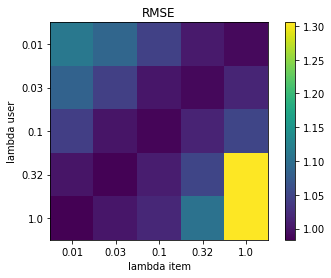

In [76]:
RMSE_test_tuning_lambdas = np.load('../results_of_lengthy_computations/RMSE_test_tuning_lambdas.npy')
lambda_users = np.logspace(-2,0,num = 5)
lambda_items = np.logspace(-2,0,num = 5)
plot_simple_heatmap(RMSE_test_tuning_lambdas, "RMSE", "lambda item",np.around(lambda_items,2), "lambda user",np.around(lambda_users,2))
plt.savefig('../plots/heatmap_tuning_lambdas.png')

- test and train

- kmean. surely not the most efficient method
- matrix factorizations
- neural network

# Output

In [ ]:
OUTPUT_PATH = '../Datasets/sample_submission.csv'
pred_submission =
create_csv_submission(ids_test, pred_submission, OUTPUT_PATH)
raise NotImplementedError